In [8]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super(CustomDropout, self).__init__()
        self.dropout = nn.Dropout(p=p)

    def forward(self, x, test_mode=False):
        if test_mode:
            return x
        else:
            return self.dropout(x)

# Layerwise_mi_figures  

/tmp/ipykernel_33/2689343676.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


False


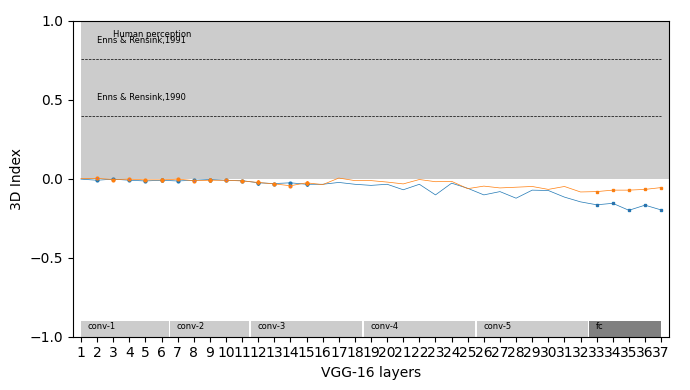

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))
    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()


# vl_simplenn

In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):

    n=len(net.features) + len(net.classifier)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        for  (sub_name, sub_layer) in (layer.named_children()):
            ltype=sub_layer.__class__.__name__

            if ltype == 'Conv2d':
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'],
                            padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
#                 temp= nn.Linear(res[i]['x'].flatten().shape[0], 4096)
#                 res[i + 1]['x'] = torch.tensor(temp),dtype=torch.float32
            elif ltype=='Dropout':
                i=i-1
#                 dropout_layer = CustomDropout(p=0.5)
#                 print(dropout_layer)
#                 res[i + 1]['x'] = dropout_layer
            elif ltype== 'ReLU':
                # if l['leak'] > 0:
                #     leak = {'leak': l['leak']}
                # else:
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1



    return res

# Extract_features

In [11]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag, run_path):
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Extract the image data from the loaded dictionary
    stim_images = stim_data['stim'][0]
    nimages = len(stim_images)
    if dagg_flag==0:
        features = []
        for ind in range(nimages):
            # Convert the numpy array to PIL Image
            image_array = stim_images[ind]
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
            print(image_tensor.shape, " is the shape")
                # Perform inference using the model
#             with torch.no_grad():
#                 output = model(image_tensor)

            # Append the features to the list
            features.append(vl_simplenn(types, image_tensor))
        return features
#     elif dagg_flag==1:
#         features = []
#         for i in range(nimages):
#             # Preprocess image
#             bimage_ip = single(stim_data[i])
#             cimage = imresize(bimage_ip, net.meta.normalization.imageSize(1:2))
#             cimage = cimage - net.meta.normalization.averageImage

#             # Evaluate network
#             net.eval({'data', cimage})

#             # Initialize scores list
#             scores = []

#             # Loop through each layer
#             for L in range(len(net.layers) - 1):
#                 scores.append(vec(net.vars(L).value))

#             # Append scores to features
#             features.append(scores)

#         return features

# Check_3d

In [12]:
import numpy as np

def check_3D(features, dist_types):
    nSet = 2
    nL = len(features[0]) - 2  # Skipping the last layers
    mi_3d = np.zeros((2, nL))
    mi_3d_raw1 = np.zeros((nL, 2))
    mi_3d_raw2 = np.zeros((nL, 2))
    
    for layers in range(nL):
        for set_idx in range(nSet):
            img_index = [((set_idx + 1) - 1) * 6 + idx for idx in range(0, 6)]
            f1 = features[img_index[0] - 1][layers]['x']
            f2 = features[img_index[1] - 1][layers]['x']
            f3 = features[img_index[2] - 1][layers]['x']
            f4 = features[img_index[3] - 1][layers]['x']
            f5 = features[img_index[4] - 1][layers]['x']
            f6 = features[img_index[5] - 1][layers]['x']
            
            # Check if any of the features are None
            if any(x is None for x in [f1, f2, f3, f4, f5, f6]):
                continue
            
            # Perform operations only if all features are valid tensors
            f1 = np.ravel(f1.detach().numpy())
            f2 = np.ravel(f2.detach().numpy())
            f3 = np.ravel(f3.detach().numpy())
            f4 = np.ravel(f4.detach().numpy())
            f5 = np.ravel(f5.detach().numpy())
            f6 = np.ravel(f6.detach().numpy())
            dI12 = distance_calculation(f1, f2, dist_types)
            dI34 = distance_calculation(f3, f4, dist_types)
            mi_3d_raw1[layers, set_idx] = (dI34 - dI12) / (dI34 + dI12)

            # Comparing Square+Y and Cuboid
            dI56 = distance_calculation(f5, f6, dist_types)
            mi_3d_raw2[layers, set_idx] = (dI56 - dI34) / (dI56 + dI34)

    mi_3d[0, :] = np.nanmean(mi_3d_raw1, axis=1)
    mi_3d[1, :] = np.nanmean(mi_3d_raw2, axis=1)
            
    return mi_3d

# Distance_calculation

In [13]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def distance_calculation(f1, f2, dist_type):
    X = np.vstack((f1, f2))
    if dist_type == 'Euclidean':
        d = np.linalg.norm(X[0] - X[1], ord=2)
    elif dist_type == 'CityBlock':
        d = np.linalg.norm(X[0] - X[1], ord=1)
    elif dist_type == 'Cosine':
        d = pdist(X, 'cosine')
    elif dist_type == 'pearson':
        d = pdist(X, 'correlation')
    elif dist_type == 'spearman':
        d = spearmanr(f1, f2).correlation
    else:
        d = np.nan
    return d

In [ ]:
import os
import time
import scipy.io as sio
from torchvision.models import vgg16, alexnet, resnet50, resnet152
# # from extract_features import extract_features
# from layerwise_mi_figures import layerwise_mi_figures
# from layerwise_mi_nonVGGfigures import layerwise_mi_nonVGGfigures
import numpy as np
# from check_3D import check_3D


# Main Code Directory location and SLASH of the OS

if __name__ == "__main__":
    # Main Code Directory location and SLASH of the OS
    main_folder = ""  # Set your main folder path
    SLASH = os.path.sep

    # Adding Path
#     dependencies_path = os.path.join(main_folder, 'dependencies')
#     matconvnet_path = os.path.join(dependencies_path, 'matconvnet-1.0-beta24')
    run_path = os.path.join('/kaggle/input/3d-dataset/CSAI_3D/vl_simplenn.py')

    # STIM
    file_name_stim = '/kaggle/input/3d-dataset/CSAI_3D/3d.mat'
    stim_data = sio.loadmat(file_name_stim)
    # print(len(stim_data), " raw value")
    # stim = stim_data['stim']
    # print(stim)
    # Networks
    type = ['/home/aditya25/Documents/CSAI_3D/imagenet-vgg-verydeep-16.mat', 'imagenet-matconvnet-vgg-verydeep-16.mat',
            'imagenet-vgg-verydeep-16_randn.mat', 'imagenet-vgg-face',
            'imagenet-caffe-alex', 'imagenet-googlenet-dag', 'imagenet-resnet-50-dag',
            'imagenet-resnet-152-dag']
    dagg_flag = [0, 0, 0, 0, 0, 1, 1, 1]
    network_short_name = ['VGG-16','Alexnet','ResNet 50', 'ResNet 152']
    typet = []
    types = vgg16(pretrained=True)
    typet.append(types)
    types = vgg16(pretrained=False)
    typet.append(types)

    features = extract_features(stim_data, types, 0, run_path)
    # Effect Reference Level
    reference_mi = [0.4, 0.76]
    reference_name = ['Enns & Rensink,1990', 'Enns & Rensink,1991']
    
    # EXTRACT FEATURES
    time_taken = []
    MI_across_layers = []
    dist_types = 'Euclidean'
    y_label = '3D Index'
    for iter, net_type in enumerate(typet[:1]):
        tstart = time.time()
        print(f'\nExtracting Features\n for {network_short_name[iter]}')
        features = extract_features(stim_data, net_type, dagg_flag[iter], run_path)
        mi_3d = check_3D(features, dist_types)
#         print(mi_3d, "is 3d")
#         print(len(mi_3d), " is the length")
        MI_across_layers.append((mi_3d[0, :], mi_3d[1, :]))
    
        # Plotting
        legend_name = ['Cond-1', 'Cond-2']
        Saving_file_name = os.path.join('..', 'results',
                                        f'Exp09-3D_metric = {dist_types}')
        print(Saving_file_name)
        if iter <= 1:
            layerwise_mi_figures(mi_3d, [], Saving_file_name, reference_mi,
                                 reference_name, legend_name, y_label)
        else:
            layerwise_mi_nonVGGfigures(mi_3d, [], Saving_file_name,
                                       reference_mi, reference_name, legend_name, y_label)
    
        time_taken.append(time.time() - tstart)

In [ ]:
MI_across_layers

In [ ]:
print(mi_3d.shape)

In [ ]:
# Plotting the effect for two networks
sel_index = [0, 2]
N = len(sel_index)
mean_data = np.zeros((N, 37))
print(len(mean_data[0]))
sem_data = np.zeros((N, 37))
for ind, idx in enumerate(sel_index):
    mean_data[ind , :] = MI_across_layers[0][0]
    mean_data[ind , :] = MI_across_layers[0][1]
legend_name = [f'Cond-{i + 1} {network_short_name[idx]}' for idx in sel_index for i in range(2)]
Saving_file_name = os.path.join('..', 'results', '3D_main_figure')
order = [0, 1]
mean_data = mean_data[order, :]
legend_name = [legend_name[i] for i in order]
layerwise_mi_figures(mean_data, [], Saving_file_name, reference_mi,
                     reference_name, legend_name, y_label)

# Comparing vgg16 versus vgg16 matconvnet
sel_index = [0, 1]
N = len(sel_index)
mean_data = np.zeros((N , 37))
sem_data = np.zeros((N, 37))
for ind, idx in enumerate(sel_index):
    mean_data[ind , :] = MI_across_layers[0][idx]
    mean_data[ind , :] = MI_across_layers[0][idx]
legend_name = [f'Cond-{i + 1} {network_short_name[idx]}' for idx in sel_index for i in range(2)]
Saving_file_name = os.path.join('..', 'results', '3D_supp_figure_VGG16_VGG16matconvenet')
order = [0,1]
mean_data = mean_data[order, :]
legend_name = [legend_name[i] for i in order]
layerwise_mi_figures(mean_data, [], Saving_file_name, reference_mi,
                     reference_name, legend_name, y_label)

# mainCode3d_distance_metric

In [ ]:
import os
import sys
import numpy as np
import scipy.io as sio
# from check_3D import check_3D
from torchvision.models import vgg16
# from layerwise_mi_figures import layerwise_mi_figures
# from extract_features import extract_features


# Main Code Directory location and SLASH of the OS
# def get_expmainfolder_slash():
#     main_folder = '..'
#     SLASH = os.sep
#     return main_folder, SLASH


# Adding Path
# main_folder, SLASH = get_expmainfolder_slash()
# sys.path.append(os.path.join(main_folder, 'dependencies', SLASH, 'matconvnet-1.0-beta24'))
# sys.path.append(os.path.join(main_folder, 'dependencies', SLASH, 'models'))
# sys.path.append(os.path.join(main_folder, 'dependencies', SLASH, 'lib'))
run_path = os.path.join('/home/aditya25/Documents/CSAI_3D/vl_setupnn.py')

# STIM
file_name_stim = '/kaggle/input/3d-dataset/CSAI_3D/3d.mat'
stim_data = sio.loadmat(file_name_stim)

# Networks
network_type = vgg16(pretrained=True)
dagg_flag = 0
dist_types = ['Euclidean', 'CityBlock', 'pearson', 'spearman']
time_taken = [None] * len(dist_types)

# Effect Reference Level
reference_mi = [0.4, 0.76]
reference_name = ['Enns & Rensink,1990', 'Enns & Rensink,1991']

# Extract Features
print('\n Extracting Features\n')
features = extract_features(stim_data, network_type, dagg_flag, run_path)

# Calculate the 3D processing Index
N = len(dist_types)
MI_across_layers = []
mean_data_condone = np.zeros((N, 37))  # Assuming 37 is the dimensionality of your data
mean_data_condtwo = np.zeros((N, 37))  # Assuming 37 is the dimensionality of your data

for ind in range(N):
    print(f'\n Distance Metric = {dist_types[ind]} \n')
    mi_3d = check_3D(features, dist_types[ind])
    mean_data_condone[ind, :] = mi_3d[0]
    mean_data_condtwo[ind, :] = mi_3d[1]

y_label = '3D Index'
Saving_file_name_1 = os.path.join('/kaggle/working/results', 'Exp09-3D_condition-1_net_VGG16')
print(Saving_file_name_1)
layerwise_mi_figures(mean_data_condone, [], Saving_file_name_1, reference_mi, reference_name, dist_types, y_label)

Saving_file_name_2 = os.path.join('/kaggle/working/results', 'Exp09-3D_condition-2_net_VGG16')
layerwise_mi_figures(mean_data_condtwo, [], Saving_file_name_2, reference_mi, reference_name, dist_types, y_label)